In [1]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import pickle
import hashlib
import string
import unicodedata
import re
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook())

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, QuantileTransformer
import lightgbm as lgb
from sklearn import metrics
import gc

from collections import defaultdict, OrderedDict, Counter
#from nltk.corpus import stopwords
#from spacy.lang.en.stop_words import STOP_WORDS
from itertools import chain

# from __future__ import print_function
np.random.seed(786)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,  KerasRegressor

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Using TensorFlow backend.
/home/mohsin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#Functions we need - Feature Selector, Fasttext_Estimator, Preprocessing Transformer, Binary_Encoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.sparse.csr import csr_matrix
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse, greater_is_better=False)    
    
# the following functions allow for a parallelized batch generator
class threadsafe_iter(object):
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()
    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def batch_generator(X_data, y_data, batch_size):
    
    #index = np.random.permutation(X_data.shape[0])    
    #X_data = X_data[index]
    #y_data = y_data[index]
    
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    #idx = 1
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        #print("")
        #print(X_batch.shape)
        #print("")
        #print('generator yielded a batch %d' % idx)
        #idx += 1
        if (counter > number_of_batches):
            counter=0
            
            
@threadsafe_generator
def batch_generator_x(X_data,batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(X_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        counter += 1
        yield np.array(X_batch)
        if (counter > number_of_batches):
            counter=0

In [3]:
num_partitions = 30
num_cores = 16
from multiprocessing import Pool, cpu_count
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 
              'there', 'about', 'once', 'during', 'out', 'very', 'having', 
              'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 
              'its', 'yours', 'such', 'into', 'most', 'itself', 'other', 
              'off', 'is', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
              'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 
              'through', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 
              'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 
              'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before', 'them',
              'same', 'and', 'been', 'have', 'in', 'will', 'does', 'yourselves', 
              'then', 'that', 'because', 'what', 'over', 'why’, ‘so', 'can', 'did',
              'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
              'myself', 'which', 'those', 'i','after', 'few', 'whom', 'being', 'if', 
              'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']

def unicodeToAscii(s):
    return  unicodedata.normalize('NFKC', s)

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"'", r"", s)
    s = re.sub(r"[.!?':;,]", r" ", s)
    s = re.sub(r"-", r"", s)
    s = re.sub(r"[^0-9a-zA-Z.!?]+", r" ", s)
    #s = re.sub(r"0", r"zero", s)
    #s = re.sub(r"1", r"one", s)
    #s = re.sub(r"2", r"two", s)
    #s = re.sub(r"3", r"three", s)
    #s = re.sub(r"4", r"four", s)
    #s = re.sub(r"5", r"five", s)
    #s = re.sub(r"6", r"six", s)
    #s = re.sub(r"7", r"seven", s)
    #s = re.sub(r"8", r"eight", s)
    #s = re.sub(r"/s/s", r"/s", s)
    return s

def _normalize_and_ngrams(sent, ngrams):
    input_list = normalizeString(sent).split()
    input_list = [word for word in input_list if word not in stop_words]
    s = input_list.copy()
    for i in range(2, ngrams+1):
        s += [' '.join(input_list[j:j+i]) for j in range(len(input_list)-i + 1)]
        #s += list((zip(*[input_list[j:] for j in range(i)])))
    return s

#tmp = "I am not a dance'r and i am a 6ixy   c-o:d;er programmer"
#print(normalizeString(tmp))
#print(_normalize_and_ngrams(tmp, 3))

class Vocab_topwords():
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        
    def fit_data(self, data, cols, ngrams=3, max_features=50000):
        c = Counter()
        for col in cols:
            c += Counter(list(chain.from_iterable(data[col].tolist())))
        for i, (w, count) in enumerate(c.most_common(max_features)):
            self.word2index[w] = i + 1
        return
    

            
            
def prepareVocab(name, data, cols, max_features):
    vocab = Vocab_topwords(name)
    vocab.fit_data(data, cols, max_features=max_features)
    
    print("Counted words:")
    print(vocab.name, len(vocab.word2index))
    return vocab

def indexesFromSentence(vocab, tokens, ngrams, max_len):
    num_list = []
    for i, item in enumerate(tokens):
        if len(num_list) == max_len:
            break
        elif item in vocab.word2index:
            num_list.append(vocab.word2index[item])
        else:
            continue
        
    if len(num_list) < max_len :
        num_list += [0]*(max_len - len(num_list) )
        
    return num_list

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def get_cat_1(x): return str(x).lower().split('/')[0]
def get_cat_2(x): return str(x).lower().split('/')[1] if len(str(x).split('/')) > 1 else -1
def get_cat_3(x): return ' '.join(str(x).lower().split('/')[2:]) if len(str(x).split('/')) > 2 else -1

def applycat1(df): 
    df['cat1'] = df['category_name'].progress_apply(get_cat_1)
    return df

def applycat2(df): 
    df['cat2'] = df['category_name'].progress_apply(get_cat_2)
    return df

def applycat3(df): 
    df['cat3'] = df['category_name'].progress_apply(get_cat_3)
    return df

def norm3grams(s): return _normalize_and_ngrams(s, 3)

def norm1grams(s): return _normalize_and_ngrams(s, 1)

def applyname(series): return series.progress_apply(norm3grams)

def applycategory(series): return series.progress_apply(norm1grams)

def index2sent1(x, name_vocab): return indexesFromSentence(name_vocab, x, 3, 10)

def name2index(series): return series.progress_apply(lambda x: index2sent1(x, all_vocab))

def applydesc(series):return series.progress_apply(norm1grams)

def index2sent2(x, desc_vocab): return indexesFromSentence(desc_vocab, x, 1, 70)

def desc2index(series): return series.progress_apply(lambda x: index2sent2(x, all_vocab))

def read_data(in_path, out_path):
    if False and os.path.exists(os.path.join(out_path, 'train_2.pkl')) and os.path.exists(os.path.join(out_path, 'test_2.pkl')):
        train_data = pd.read_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data  = pd.read_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
    
    else:
        train_data = pd.read_table(os.path.join(in_path, 'train.tsv'))
        test_data  = pd.read_table(os.path.join(in_path, 'test.tsv'))
    
        train_rows = len(train_data)
        data = pd.concat([train_data, test_data], ignore_index=True)
        
        data['name'] = data['name'].astype(str)
        data['brand_name_cat'] = data['brand_name'].astype(str)
        data['item_description'] = data['item_description'].astype(str)
        data['desc_words'] = data['item_description'].apply(lambda x: len(str(x).split()))
        data['desc_chars'] = data['item_description'].apply(lambda x: len(str(x)))
        data['name_chars'] = data['name'].apply(len)
        #ddata = dd.from_pandas(data, 4)
        data['category_words'] = parallelize_dataframe(data['category_name'].astype(str), applycategory)
        
        data = applycat1(data)
        data = applycat2(data)
        data = applycat3(data)
        data.fillna(-1, inplace=True)
        cat_cols = ['category_name', 'brand_name', 'item_condition_id', 'cat1', 'cat2', 'cat3']
        print("Label enoding categoricals")
        for col in cat_cols:
            data[col] = LabelEncoder().fit_transform(data[col].astype(str)).astype(np.int32)
            
        print("Tokenizing text columns")
        data['name'] = parallelize_dataframe(data['name'], applyname)

        print("Preparing vocabs")
        #global name_vocab
        #name_vocab = prepareVocab('name', data, ['name'], 50000)
        global all_vocab
        all_vocab = prepareVocab('name', data, ['name', 'category_words', 'brand_name_cat'], 100000)
        
        data['name'] = name2index(data['name'])
        #del name_vocab
        
        print("Transforming text to sequences")
        data['item_description'] = parallelize_dataframe(data['item_description'], applydesc)
        #global desc_vocab
        #desc_vocab = prepareVocab('item_description', data, ['item_description'], 250000)
        data['item_description'] = desc2index(data['item_description'])
        #del desc_vocab
        del data['category_words']
        
        train_data = data.iloc[: train_rows, :]
        train_data = train_data.loc[(train_data.price >= 1) & (train_data.price <= 2100), :].reset_index(drop=True)
        test_data  = data.iloc[train_rows: , :].reset_index(drop=True)
        
        del train_data['test_id']
        del test_data['train_id']
        del data
        gc.collect()
        print("Writing out new pickles dataframes")
        train_data.to_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data.to_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data

In [4]:
import keras.backend as K
from keras.engine.topology import Layer
class ZeroMaskedEntries(Layer):
    """
    This layer is called after an Embedding layer.
    It zeros out all of the masked-out embeddings.
    It also swallows the mask without passing it on.
    You can change this to default pass-on behavior as follows:

    def compute_mask(self, x, mask=None):
        if not self.mask_zero:
            return None
        else:
            return K.not_equal(x, 0)
    """

    def __init__(self, **kwargs):
        self.support_mask = True
        super(ZeroMaskedEntries, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[1]
        self.repeat_dim = input_shape[2]

    def call(self, x, mask=None):
        mask = K.cast(mask, 'float32')
        mask = K.repeat(mask, self.repeat_dim)
        mask = K.permute_dimensions(mask, (0, 2, 1))
        return x * mask

    def compute_mask(self, input_shape, input_mask=None):
        return None
    
def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)

    # number of that rows are not all zeros
    n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)

    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False) / n

    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3 
    return (shape[0], shape[2])

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
class EM_NNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, embed_cols=None, dense_cols=None, embed_dims=None, 
                 text_embed_cols=None, text_embed_seq_lens=None, 
                 text_embed_dims=None,
                 num_layers=2, multiprocess=False,
                layer_activations=None, layer_dims=None,layer_dropouts=None, epochs=20, batchsize=32,
                optimizer_kwargs=None, val_size=0.1, verbose=1, seed=1):
        
        self.embed_cols = embed_cols
        self.dense_cols = dense_cols
        self.embed_dims = embed_dims
        self.text_embed_cols = text_embed_cols
        self.text_embed_dims = text_embed_dims
        #self.text_embed_tokenizers = text_embed_tokenizers
        self.text_embed_seq_lens = text_embed_seq_lens
        self.dense_dims = None
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.layer_dropouts = layer_dropouts
        self.epochs = epochs
        self.batchsize = batchsize
        self.optimizer_kwargs = optimizer_kwargs
        self.val_size = val_size
        self.verbose = verbose
        self.multiprocess = multiprocess
        self.seed = seed
        self.model = None
        if self.dense_cols:
            self.dense_dims = len(self.dense_cols)
            
    def _splitX(self, X):
        X_splits = []
        
        if self.embed_cols:
            for col in self.embed_cols :
                X_splits.append(np.asarray(X[col]))
                
        if self.text_embed_cols:
            for i, col in enumerate(self.text_embed_cols):
                X_splits.append(np.asarray([*X[col].values]))
                
        if self.dense_cols:
            X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
            
        return X_splits
    
    
    def _build_model(self):
        np.random.seed(786)
        model_inputs = []
        model_layers = []
        
        if self.embed_cols:
            for col, dim in zip(self.embed_cols, self.embed_dims):
                x1 = Input( shape=(1,), name=col)
                model_inputs.append(x1)
                x1 = Embedding(input_dim=dim[0], output_dim=dim[1],)(x1)
                #x1 = Dropout(0.1)(x1)
                x1 = Reshape(target_shape=(dim[1],))(x1)
                model_layers.append(x1)
                
        if self.text_embed_cols:
            dim, seq_len = self.text_embed_dims[0], self.text_embed_seq_lens[0]
            embed_layer = Embedding(input_dim=dim[0], output_dim=dim[1],)
            for col, dim, seq_len in zip(self.text_embed_cols, 
                                                self.text_embed_dims, 
                                                self.text_embed_seq_lens):
                x3 = Input( shape=(seq_len,))
                model_inputs.append(x3)
                x3 = embed_layer(x3)
                print(x3.shape)
                #x3 = ZeroMaskedEntries()(x3)
                #x3 = Lambda(mask_aware_mean, mask_aware_mean_output_shape)(x3)
                #x3 = Conv1D(16, return_sequences=True)(x3)
                x3 = GlobalAveragePooling1D()(x3)
                #x3 = Reshape(target_shape=(dim[1],))(x3)
                model_layers.append(x3)
                
        if self.dense_cols:
            x2 = Input( shape=(self.dense_dims, ), name='dense_cols')
            model_inputs.append(x2)
            model_layers.append(x2)
        print(model_layers)
        x = concatenate(model_layers)
        
        if self.num_layers > 0:
            for dim, drops in zip(self.layer_dims, self.layer_dropouts):
                x = BatchNormalization()(x)
                x = Dropout(rate=drops, seed=self.seed)(x)
                x = Dense(dim, kernel_initializer='he_normal')(x)
                #x = Dense(dim, activation='selu', kernel_initializer='he_normal')(x)
                x = LeakyReLU()(x)
        
        x = BatchNormalization()(x)
        x = Dropout(0.02, seed=self.seed)(x)
        output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)
        
        model = Model(inputs=model_inputs, outputs=output)
        #print(model.summary())
        adam = RMSprop(lr=0.004, decay=0.004)
        #adam = Nadam()
        model.compile(optimizer=adam, loss='mean_squared_error')
        
        return model 
    
    
    def fit(self, X, y):
        self.model = self._build_model()
        if self.val_size > 0:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=self.seed)
            print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
            
            callbacks= [ModelCheckpoint("embed_NN_"+str(self.seed)+".check", save_best_only=True, verbose=1)]
            if self.multiprocess == False:
                self.model.fit(self._splitX(X_train), y_train, batch_size=self.batchsize, epochs=self.epochs,
                               verbose=self.verbose,
                              validation_data=(self._splitX(X_val), y_val), shuffle=True,
                              callbacks=callbacks)
            else:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=1)

        else:
            self.model.fit(self._splitX(X), y, batch_size=self.batchsize, epochs=self.epochs,
               verbose=self.verbose, shuffle=True,)

        
        return self
    
    def predict(self, X, y=None):
        
        if self.model:
            self.model = load_model("embed_NN_"+str(self.seed)+".check")
            y_hat = self.model.predict(self._splitX(X))
        else:
            raise ValueError("Model not fit yet")
            
        return y_hat

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
class EM_NNRegressor2(BaseEstimator, RegressorMixin):
    
    def __init__(self, embed_cols=None, dense_cols=None, embed_dims=None, embed_weights=None,
                 text_embed_cols=None, text_embed_seq_lens=None, 
                 text_embed_dims=None, text_embed_weights=None,
                 num_layers=2, multiprocess=False,
                layer_activations=None, layer_dims=None,layer_dropouts=None, epochs=20, batchsize=32,
                optimizer_kwargs=None, val_size=0.1, verbose=1, seed=1):
        
        self.embed_cols = embed_cols
        self.dense_cols = dense_cols
        self.embed_dims = embed_dims
        self.embed_weights = embed_weights
        self.text_embed_cols = text_embed_cols
        self.text_embed_dims = text_embed_dims
        self.text_embed_weights = text_embed_weights
        self.text_embed_seq_lens = text_embed_seq_lens
        self.dense_dims = None
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.layer_dropouts = layer_dropouts
        self.epochs = epochs
        self.batchsize = batchsize
        self.optimizer_kwargs = optimizer_kwargs
        self.val_size = val_size
        self.verbose = verbose
        self.multiprocess = multiprocess
        self.seed = seed
        self.model = None
        if self.dense_cols:
            self.dense_dims = len(self.dense_cols)
            
    def _splitX(self, X):
        X_splits = []
        
        if self.embed_cols:
            for col in self.embed_cols :
                X_splits.append(np.asarray(X[col]))
                
        if self.text_embed_cols:
            for i, col in enumerate(self.text_embed_cols):
                X_splits.append(np.asarray([*X[col].values]))
                
        if self.dense_cols:
            X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
            
        return X_splits
    
    
    def _build_model(self):
        np.random.seed(786)
        model_inputs = []
        model_layers = []
        
        if self.embed_cols:
            for col, dim, weights in zip(self.embed_cols, self.embed_dims, self.embed_weights):
                x1 = Input( shape=(1,), name=col)
                model_inputs.append(x1)
                x1 = Embedding(input_dim=dim[0], output_dim=dim[1], weights=weights, trainable=False)(x1)
                #x1 = Dropout(0.1)(x1)
                x1 = Reshape(target_shape=(dim[1],))(x1)
                model_layers.append(x1)
                
        if self.text_embed_cols:
            for col, dim, seq_len, weights in zip(self.text_embed_cols, 
                                                self.text_embed_dims, 
                                                self.text_embed_seq_lens,
                                                self.text_embed_weights):
                x3 = Input( shape=(seq_len,))
                model_inputs.append(x3)
                x3 = Embedding(input_dim=dim[0], output_dim=dim[1], input_length=seq_len,
                              weights=weights, trainable=False)(x3)
                #x3 = ZeroMaskedEntries()(x3)
                #x3 = Lambda(mask_aware_mean, mask_aware_mean_output_shape)(x3)
                #x3 = Conv1D(16, return_sequences=True)(x3)
                x3 = GlobalAveragePooling1D()(x3)
                x3 = Reshape(target_shape=(dim[1],))(x3)
                model_layers.append(x3)
                
        if self.dense_cols:
            x2 = Input( shape=(self.dense_dims, ), name='dense_cols')
            model_inputs.append(x2)
            model_layers.append(x2)
        print(model_layers)
        x = concatenate(model_layers)
        
        if self.num_layers > 0:
            for dim, drops in zip(self.layer_dims, self.layer_dropouts):
                x = BatchNormalization()(x)
                x = Dropout(rate=drops, seed=self.seed)(x)
                x = Dense(dim, kernel_initializer='he_normal')(x)
                #x = Dense(dim, activation='selu', kernel_initializer='he_normal')(x)
                x = PReLU()(x)
        
        x = BatchNormalization()(x)
        x = Dropout(0.02, seed=self.seed)(x)
        output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)
        
        model = Model(inputs=model_inputs, outputs=output)
        #print(model.summary())
        #adam = RMSprop(lr=0.001, decay=0.001)
        #adam = Adam(lr=0.001, decay=0)
        adam= Nadam()
        model.compile(optimizer=adam, loss='mean_squared_error')
        
        return model 
    
    
    def fit(self, X, y):
        self.model = self._build_model()
        if self.val_size > 0:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=self.seed)
            print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
            
            callbacks= [ModelCheckpoint("embed_NN_"+str(self.seed)+".check", save_best_only=True, verbose=1)]
            if self.multiprocess == False:
                self.model.fit(self._splitX(X_train), y_train, batch_size=self.batchsize, epochs=self.epochs,
                               verbose=self.verbose,
                              validation_data=(self._splitX(X_val), y_val), shuffle=True,
                              callbacks=callbacks)
            else:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=1)

        else:
            self.model.fit(self._splitX(X), y, batch_size=self.batchsize, epochs=self.epochs,
               verbose=self.verbose, shuffle=True,)

        
        return self
    
    def predict(self, X, y=None):
        
        if self.model:
            self.model = load_model("embed_NN_"+str(self.seed)+".check")
            y_hat = self.model.predict(self._splitX(X))
        else:
            raise ValueError("Model not fit yet")
            
        return y_hat

In [7]:
%%time
train_data, test_data = read_data("../input", "./")

100%|██████████| 2175894/2175894 [00:04<00:00, 517456.11it/s]


Label enoding categoricals
Tokenizing text columns


100%|██████████| 72529/72529 [00:01<00:00, 54084.30it/s]

Preparing vocabs


  1%|          | 13137/2175894 [00:00<00:16, 131369.19it/s]

Counted words:
name 100000


100%|██████████| 2175894/2175894 [00:13<00:00, 155945.37it/s]


Transforming text to sequences


100%|██████████| 2175894/2175894 [00:23<00:00, 92242.77it/s] 


Writing out new pickles dataframes
CPU times: user 2min 7s, sys: 7.17 s, total: 2min 15s
Wall time: 2min 29s


In [8]:
nnet = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                      embed_dims=[(6000, 100),(1500, 100), (5,4), (15,6), (120, 20), (900, 30)],
                      text_embed_cols=['name', 'item_description'],
                      text_embed_dims=[(100001, 150), (100001, 150)],
                      text_embed_seq_lens =[10, 70], 
                      #text_embed_cols=['name'],
                      #text_embed_dims=[(50000, 80)],
                      #text_embed_seq_lens =[10], 
                      dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars'],
                      epochs=8,
                      batchsize=2048,
                      num_layers = 1,
                      layer_dropouts=[0.1],
                      layer_dims=[300],
                      val_size=0.05,
                      seed=1,
                     )

nnet.fit(train_data, np.log1p(train_data.price))

(?, 10, 150)
(?, 70, 150)
[<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'reshape_2/Reshape:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'reshape_3/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_4/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'reshape_5/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_6/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'global_average_pooling1d_1/Mean:0' shape=(?, 150) dtype=float32>, <tf.Tensor 'global_average_pooling1d_2/Mean:0' shape=(?, 150) dtype=float32>, <tf.Tensor 'dense_cols:0' shape=(?, 4) dtype=float32>]
(1407577, 15) (74084, 15) (1407577,) (74084,)
Train on 1407577 samples, validate on 74084 samples
Epoch 1/8
1407577/1407577 [==============================] - 18s 13us/step - loss: 0.6221 - val_loss: 0.2121
Epoch 2/8
1407577/1407577 [==============================] - 16s 12us/step - loss: 0.1826 - val_loss: 0.1818
Epoch 3/8
1407577/1407577 [==============================] - 16s 12u

EM_NNRegressor(batchsize=2048,
        dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars'],
        embed_cols=['brand_name', 'category_name', 'item_condition_id', 'cat1', 'cat2', 'cat3'],
        embed_dims=[(6000, 100), (1500, 100), (5, 4), (15, 6), (120, 20), (900, 30)],
        epochs=8, layer_activations=None, layer_dims=[300],
        layer_dropouts=[0.1], multiprocess=False, num_layers=1,
        optimizer_kwargs=None, seed=1,
        text_embed_cols=['name', 'item_description'],
        text_embed_dims=[(100001, 150), (100001, 150)],
        text_embed_seq_lens=[10, 70], val_size=0.05, verbose=1)

In [13]:
nnet.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition_id (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
cat1 (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
cat2 (Inpu

In [83]:
nn_preds_1 = nnet.predict(test_data)

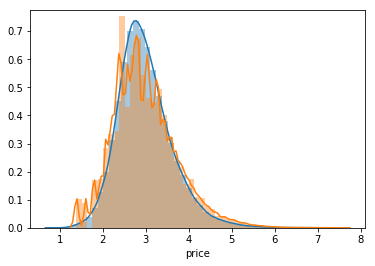

In [84]:
import seaborn as sns
import  matplotlib.pyplot as plt
sns.distplot(nn_preds_1)
sns.distplot(np.log1p(train_data.price))
plt.show()

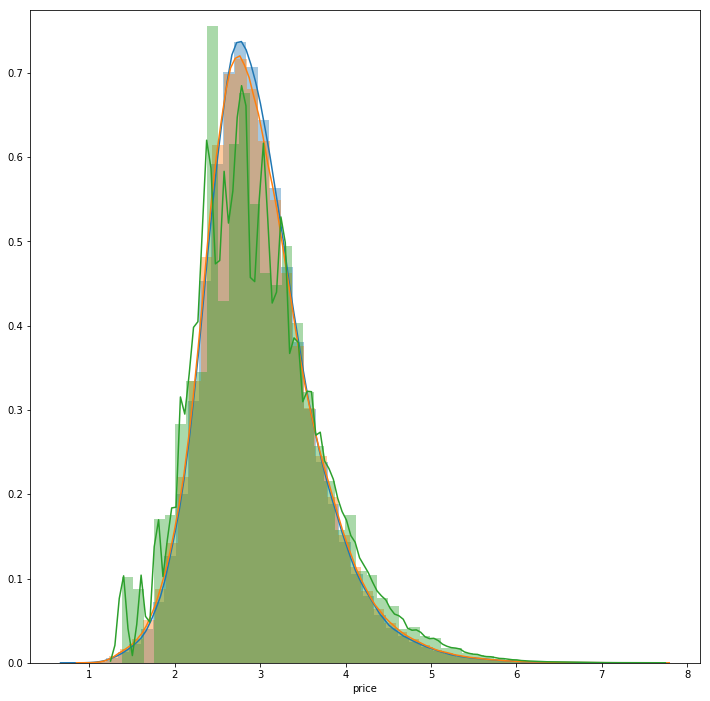

In [85]:
train_preds = nnet.predict(train_data)
plt.figure(figsize=(12,12))
sns.distplot(nn_preds_1)
sns.distplot(train_preds)
sns.distplot(np.log1p(train_data.price))
plt.show()

In [86]:
train_data.price.value_counts()

10.0      99416
12.0      78986
14.0      76655
16.0      66413
9.0       63643
8.0       61564
15.0      58082
20.0      56323
7.0       52268
18.0      41243
24.0      40797
11.0      39786
19.0      37729
13.0      36800
26.0      33531
25.0      32450
6.0       32260
5.0       31502
21.0      28996
22.0      28012
30.0      25386
29.0      21793
17.0      21334
34.0      18816
36.0      18718
3.0       18703
31.0      17414
40.0      16545
4.0       16139
35.0      15943
          ...  
671.0         1
1260.0        1
668.0         1
719.0         1
428.0         1
1150.0        1
755.0         1
774.0         1
771.0         1
770.0         1
407.0         1
766.0         1
1058.0        1
764.0         1
760.0         1
1064.0        1
1070.0        1
754.0         1
727.0         1
1081.0        1
414.0         1
749.0         1
745.0         1
744.0         1
1095.0        1
68.5          1
321.5         1
1140.0        1
45.5          1
840.0         1
Name: price, Length: 827

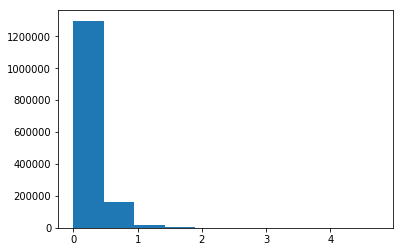

In [87]:
train_data['preds'] = train_preds
train_data['err'] = np.abs(train_data['preds'] - np.log1p(train_data.price))
plt.hist(train_data['err'])
plt.show()

In [88]:
train = pd.read_table("../input/train.tsv")
print(train.shape)
train = train.loc[(train.price >= 1) & (train.price <= 2100)].reset_index(drop=True)
print(train.shape, train_data.shape)
train.loc[train_data.err > 1, :]

(1482535, 8)
(1481661, 8) (1481661, 14)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
36,36,Black bag 30,3,Women/Women's Handbags/Totes & Shoppers,NaN,209.0,0,Pre-owned. Some light scratches on hardware co...
157,157,Opi polish Hold for Chi Thuy,1,Beauty/Makeup/Nails,NaN,150.0,1,New in box
171,171,Tranquilo mat,2,Kids/Gear/Baby Gyms & Playmats,NaN,91.0,0,"Awesome, but we only had to use it a handful o..."
216,216,YSL OTL BDJ Chevrette 2A Clutch NEW,2,Vintage & Collectibles/Bags and Purses/Clutch,YSL Yves Saint Laurent,470.0,1,Price firm. All offers will be declined. Origi...
264,264,Ricky Garner,1,Other/Other/Other,NaN,650.0,1,No description yet
413,413,Necklace,3,Vintage & Collectibles/Jewelry/Necklace,NaN,100.0,1,Ruby and diamond flat chain necklace it is 10k...
446,446,Rae Dunn Tea pot lid for Jleman,1,Home/Kitchen & Dining/Coffee & Tea Accessories,Rae Dunn,9.0,0,No description yet
546,546,Ring,3,Women/Jewelry/Rings,NaN,95.0,1,Diamond ring. Stamped10k weighing approximatel...
664,664,large fitbit charge 2,1,Sports & Outdoors/Other/Other,NaN,10.0,0,[rm] For all four
766,766,Louis Vuitton wallet,2,Women/Women's Accessories/Wallets,Louis Vuitton,15.0,0,"Not used it was a gift, great condition"


In [89]:
nnet.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condi

In [90]:
embed_weights = [nnet.model.layers[9].get_weights(), 
                nnet.model.layers[10].get_weights(),
                nnet.model.layers[11].get_weights(),
                nnet.model.layers[12].get_weights(),
                nnet.model.layers[13].get_weights(),
                nnet.model.layers[14].get_weights()]
text_embed_weights = [nnet.model.layers[8].get_weights(),
                     nnet.model.layers[8].get_weights()]

In [1]:
nnet2 = EM_NNRegressor2(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                      embed_dims=[(6000, 30),(1500, 15), (5,4), (15,4), (120, 10), (900, 15)],
                      embed_weights = embed_weights,
                      text_embed_cols=['name', 'item_description'],
                      text_embed_dims=[(300000, 300), (300000, 300)],
                      text_embed_seq_lens =[10, 20], 
                      text_embed_weights = text_embed_weights,
                      dense_cols=['shipping'],
                      epochs=10,
                      batchsize=512*4,
                      num_layers = 1,
                      layer_dropouts=[0.1, 0.1],
                      layer_dims=[300, 50],
                      val_size=0.05,
                      seed=1,
                     )

nnet2.fit(train_data, np.log1p(train_data.price))

NameError: name 'EM_NNRegressor2' is not defined